In [19]:
import tweepy
import os
import re
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
API_KEY = 'XO8NmVeoGjHQh0TLVamD6ABmO'
API_SECRET_KEY = 'aXYlbOAjis1eKPnXEhCU9iDQNzdYuMcJDXRHREA4o3ukn1ZKvJ'
ACCESS_TOKEN = '943525676186869760-rYpA0V2LNEhmLPFlSn0tptCeO7zUtpg'
ACCESS_SECRET = '59Ts2d33oxC7L4ft85kIzGDsTQQY5AEWPB2ZjtL54T8D3'

This function is responsible for authenticating and creating an instance of the Twitter API using Tweepy. It 
initializes an OAuthHandler object with the API_KEY and API_SECRET_KEY, sets the access token using ACCESS_TOKEN and 
ACCESS_SECRET, and creates a Tweepy API instance with the given authentication details. This API instance is then 
returned and used throughout the script to fetch tweets.

In [21]:
def create_api():
    auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    api = tweepy.API(auth, wait_on_rate_limit=True)
    return api

This function takes a raw tweet as input and cleans it by removing mentions, URLs, and non-alphanumeric characters 
using a regular expression. It then returns the cleaned tweet text as a string.

In [22]:
def clean_tweet(tweet):
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet).split())

This function fetches tweets from the Twitter API using the provided API instance, search query, and count (
default is 1000). It filters tweets based on the query, language (English), tweet mode (extended for full tweet 
text), and tweets posted within a specified time window. The fetched tweets are then cleaned and stored in a list of 
dictionaries containing the cleaned tweet text, which is returned.

In [23]:
def get_tweets(api, query, count=1000):
    tweets = []
    until_datetime = datetime.now() - timedelta(hours=6)
    until_str = until_datetime.strftime("%Y-%m-%d")

    fetched_tweets = tweepy.Cursor(api.search_tweets, q=query, lang="en", tweet_mode="extended", until=until_str).items(
        count)

    for tweet in fetched_tweets:
        parsed_tweet = {'text': clean_tweet(tweet.full_text)}
        tweets.append(parsed_tweet)

    return tweets

This function calls the get_tweets() function to fetch tweets and then labels them based on their sentiment using 
the NLTK SentimentIntensityAnalyzer. The polarity score for each cleaned tweet is determined using the analyzer, 
and the tweet is labeled as positive (2), neutral (1), or negative (0) based on the polarity score. The function 
returns a list of tuples, each containing the cleaned tweet text and its corresponding sentiment label.

In [24]:
def get_labeled_tweets(api, query, count=1000):
    tweets = get_tweets(api, query, count)
    cleaned_tweets = [clean_tweet(tweet['text']) for tweet in tweets]

    from nltk.sentiment import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    labeled_tweets = []
    for tweet in cleaned_tweets:
        sentiment = sia.polarity_scores(tweet)['compound']
        if sentiment >= 0.05:
            labeled_tweets.append((tweet, 2))
        elif sentiment <= -0.05:
            labeled_tweets.append((tweet, 0))
        else:
            labeled_tweets.append((tweet, 1))

    return labeled_tweets

This function builds a TensorFlow Sequential model for sentiment analysis. It takes a tokenizer and a number of 
labels as input and creates a model with an Embedding layer, GlobalAveragePooling1D layer, Dense layer with ReLU 
activation, and a final Dense layer with softmax activation for the sentiment labels. The model is compiled using the 
Adam optimizer, SparseCategoricalCrossentropy loss, and accuracy metric. The compiled model is then returned.

In [25]:
def create_model(tokenizer, labels_count):
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=40),
        GlobalAveragePooling1D(),
        Dense(16, activation='relu'),
        Dense(labels_count, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

This function is responsible for training and saving the sentiment analysis model and tokenizer. It fetches 
labeled tweets using get_labeled_tweets(), tokenizes the tweet text, and pads the sequences. The training data is 
then split into training and test sets using a 67:33 ratio. The model is created, compiled, and trained using the 
create_model() function and early stopping callback. The trained model and tokenizer are then saved to disk as .h5 
and .pickle files, respectively.

In [26]:
def train_and_save_model(query):
    api = create_api()
    labeled_tweets = get_labeled_tweets(api, query)
    train_data = [tweet for tweet, label in labeled_tweets]
    train_labels = [label for tweet, label in labeled_tweets]

    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_data)

    train_sequences = tokenizer.texts_to_sequences(train_data)
    padded_train_sequences = pad_sequences(train_sequences, maxlen=40, truncating="post", padding="post")

    X_train, X_test, y_train, y_test = train_test_split(padded_train_sequences, np.array(train_labels), test_size=0.33,
                                                        random_state=42)

    model = create_model(tokenizer, labels_count=3)

    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10, callbacks=[early_stopping])

    model_file = f'{query}_model.h5'
    tokenizer_file = f'{query}_tokenizer.pickle'

    model.save(model_file)

    with open(tokenizer_file, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

This function loads a pre-trained model and tokenizer from disk and predicts the sentiment of a given input text. 
If the required model and tokenizer files do not exist, the function calls train_and_save_model() to train and save a 
new model. The input text is tokenized and padded using the loaded tokenizer, and the sentiment prediction is made 
using the loaded model. The function returns the predicted sentiment probabilities.

In [27]:
def predict_sentiment(query, text):
    model_file = f'{query}_model.h5'
    tokenizer_file = f'{query}_tokenizer.pickle'

    if not os.path.exists(model_file) or not os.path.exists(tokenizer_file):
        train_and_save_model(query)

    with open(tokenizer_file, 'rb') as handle:
        tokenizer = pickle.load(handle)

    model = tf.keras.models.load_model(model_file)

    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=40, truncating="post", padding="post")

    return model.predict(padded_sequence)

This part of the script is responsible for executing the entire sentiment analysis process. It starts by prompting 
the user to input the stock or crypto symbol they wish to analyze. Then, it fetches tweets related to the given 
symbol using the get_tweets() function. For each fetched tweet, the script cleans the tweet text, predicts its 
sentiment using the predict_sentiment() function, and updates the sentiments dictionary accordingly.

Enter the stock or crypto symbol:  bitcoin


Epoch 1/100
67/67 [==============================] - 0s 3ms/step - loss: 1.0542 - accuracy: 0.4149 - val_loss: 0.9880 - val_accuracy: 0.4515
Epoch 2/100
67/67 [==============================] - 0s 1ms/step - loss: 0.9486 - accuracy: 0.5328 - val_loss: 0.8792 - val_accuracy: 0.6909
Epoch 3/100
67/67 [==============================] - 0s 1ms/step - loss: 0.8233 - accuracy: 0.7239 - val_loss: 0.7552 - val_accuracy: 0.7182
Epoch 4/100
67/67 [==============================] - 0s 1ms/step - loss: 0.6851 - accuracy: 0.7896 - val_loss: 0.6556 - val_accuracy: 0.7485
Epoch 5/100
67/67 [==============================] - 0s 1ms/step - loss: 0.5670 - accuracy: 0.8045 - val_loss: 0.5931 - val_accuracy: 0.7364
Epoch 6/100
67/67 [==============================] - 0s 1ms/step - loss: 0.4695 - accuracy: 0.8209 - val_loss: 0.5469 - val_accuracy: 0.7758
Epoch 7/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3882 - accuracy: 0.8537 - val_loss: 0.5133 - val_accuracy: 0.7727
Epoch 8/100
6

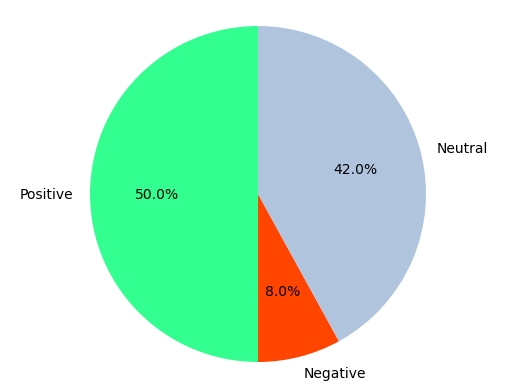


Note: This sentiment analysis might not accurately capture sarcasm or nuanced expressions of sentiment.


In [28]:
query = input("Enter the stock or crypto symbol: ").lower()
tweets = get_tweets(create_api(), query, count=100)
sentiments = {"positive": 0, "neutral": 0, "negative": 0}

for tweet in tweets:
    text = clean_tweet(tweet['text'])
    sentiment_prediction = predict_sentiment(query, text)
    sentiment_label = sentiment_prediction.argmax(axis=-1)[0]

    if sentiment_label == 0:
        sentiments["negative"] += 1
    elif sentiment_label == 1:
        sentiments["neutral"] += 1
    else:
        sentiments["positive"] += 1
        
total = sum(sentiments.values())
positive_percentage = sentiments["positive"] / total * 100
negative_percentage = sentiments["negative"] / total * 100
neutral_percentage = sentiments["neutral"] / total * 100

print(f'Sentiment analysis for {query}')
print(f'Positive: {positive_percentage:.2f}%')
print(f'Negative: {negative_percentage:.2f}%')
print(f'Neutral: {neutral_percentage:.2f}%')

# Create the pie chart
sizes = [positive_percentage, negative_percentage, neutral_percentage]
labels = ['Positive', 'Negative', 'Neutral']
colors = ['#33FF90', '#FF4500', '#B0C4DE']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')

# Display the chart
plt.show()

print('\nNote: This sentiment analysis might not accurately capture sarcasm or nuanced expressions of sentiment.')